In [68]:
#!/usr/bin/env python3.6
# -*- coding: utf-8 -*-

In [69]:
# Imports
import sys
import joblib
import numpy as np
from matplotlib import animation
from IPython.display import HTML
from matplotlib import pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3

In [70]:
#np.random.seed(20)
np.set_printoptions(threshold=sys.maxsize)

In [71]:
%matplotlib inline

In [72]:
%store -r X_relative_footsteps_acc
%store -r Y_relative_footsteps_acc
print(X_relative_footsteps_acc.shape)
print(Y_relative_footsteps_acc.shape)

(9991, 28)
(9991, 8)


# Multivariate Linear Regression (Foot prediction)

In [73]:
import sklearn
from sklearn import metrics
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [74]:
X_relative_footsteps_acc[0, :]

array([ 0.        ,  0.        ,  0.        ,  0.0291372 ,  0.14719469,
        0.02297609,  0.00390969,  0.00879887, -0.0143033 ,  0.22920228,
        0.1869078 , -0.40553803,  0.22966338, -0.20612911, -0.40550052,
       -0.26193804,  0.13096712, -0.40069671, -0.25670755, -0.15245044,
       -0.4004477 ,  0.        ,  1.        ,  1.        ,  0.        ,
        0.        ,  0.        , -0.1       ])

In [75]:
# Entries where FL is in support
idxs = np.where(X_relative_footsteps_acc[:, 21] == 0)[0]
X_relative_footsteps_acc_FL_support = X_relative_footsteps_acc[idxs]
Y_relative_footsteps_acc_FL_support = Y_relative_footsteps_acc[idxs]

## Predict FL foot -> x

In [76]:
X_relative_footsteps_acc_FL_support.shape

(4992, 28)

In [77]:
X_relative_footsteps_acc_FL_support[0, :]

array([ 0.        ,  0.        ,  0.        ,  0.0291372 ,  0.14719469,
        0.02297609,  0.00390969,  0.00879887, -0.0143033 ,  0.22920228,
        0.1869078 , -0.40553803,  0.22966338, -0.20612911, -0.40550052,
       -0.26193804,  0.13096712, -0.40069671, -0.25670755, -0.15245044,
       -0.4004477 ,  0.        ,  1.        ,  1.        ,  0.        ,
        0.        ,  0.        , -0.1       ])

In [78]:
Y_relative_footsteps_acc_FL_support[0, :]

array([ 0.23097709,  0.20958901,  0.22783941, -0.18877447, -0.25504919,
        0.15667753, -0.26330079, -0.12892046])

### Linear Regression

In [82]:
# Input
X = np.hstack((X_relative_footsteps_acc_FL_support[:, :3], # prev velocity command
               X_relative_footsteps_acc_FL_support[:, -3:], # commanded velocity command
               X_relative_footsteps_acc_FL_support[:, 9:11], # FL (x,y) position
               X_relative_footsteps_acc_FL_support[:, 12:14], # FR (x,y) position
               X_relative_footsteps_acc_FL_support[:, 15:17], # RL (x,y) position
               X_relative_footsteps_acc_FL_support[:, 18:20])) # RR (x,y) position

# Target
Y = np.array([Y_relative_footsteps_acc_FL_support[:, 0]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle=True)

# Create the model
model_fl_relative_support_x = LinearRegression()

# Fit the model
model_fl_relative_support_x.fit(X_train, Y_train)

# Predict
predictions = model_fl_relative_support_x.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.7460815225813583
RMSE:  0.012733930779545266
The lowest error is:  6.857895675504988e-07
The highest error is:  0.06196214409855891
The avg. error is:  0.008782949638491917


In [83]:
model_fl_relative_support_x.coef_

array([[ 0.01413195,  0.08612233, -0.03156993, -0.05643011, -0.00413237,
        -0.0477759 ,  0.92487447, -0.29943536, -0.44119994, -0.20247431,
         0.12392624,  0.0290928 , -1.14179652, -0.55357766]])

In [84]:
model_fl_relative_support_x.intercept_

array([-0.21199407])

Text(0, 0.5, 'Predictions')

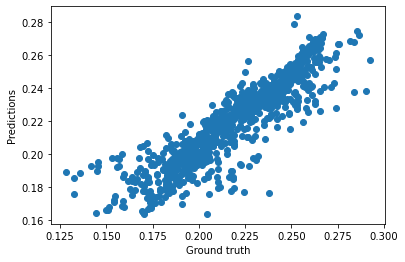

In [85]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Ground truth")
plt.ylabel("Predictions")

In [86]:
#%store model_fl_relative_support_x

In [87]:
#for idx, prediction in enumerate(predictions):
#    print(f'Start: {X_test[idx, 6]}. Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

In [88]:
# Save model
#joblib.dump(model_fl_relative_support_x, "/home/itaouil/workspace/aliengo_ws/src/aliengo_navigation/models/protocol3/relative/model_fl_relative_support_x.sav")

### Predict FL foot -> y

In [102]:
# Input
X = np.hstack((X_relative_footsteps_acc_FL_support[:, :3], # prev velocity command
               X_relative_footsteps_acc_FL_support[:, -3:], # commanded velocity command
               X_relative_footsteps_acc_FL_support[:, 9:11], # FL (x,y) position
               X_relative_footsteps_acc_FL_support[:, 12:14], # FR (x,y) position
               X_relative_footsteps_acc_FL_support[:, 15:17], # RL (x,y) position
               X_relative_footsteps_acc_FL_support[:, 18:20])) # RR (x,y) position

# Target
Y = np.array([Y_relative_footsteps_acc_FL_support[:, 1]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle=True)

# Create the model
model_fl_relative_support_y = LinearRegression()

# Fit the model
model_fl_relative_support_y.fit(X_train, Y_train)

# Predict
predictions = model_fl_relative_support_y.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.9153215271669917
RMSE:  0.01026619063199859
The lowest error is:  7.630714669998317e-06
The highest error is:  0.07458832196155604
The avg. error is:  0.0067709963051684995


In [103]:
model_fl_relative_support_y.coef_

array([[ 0.00204702, -0.14732721, -0.11998248, -0.016389  , -0.04688762,
        -0.05128605,  0.1281158 ,  0.8935781 ,  0.16080997, -0.5793612 ,
         0.1061211 ,  0.10422217,  0.16393235,  0.32489343]])

In [104]:
model_fl_relative_support_y.intercept_

array([-0.04112222])

Text(0, 0.5, 'Predictions')

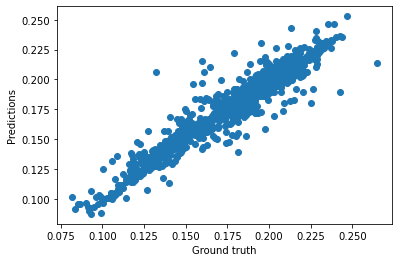

In [105]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Ground truth")
plt.ylabel("Predictions")

In [48]:
#%store model_fl_relative_support_y

In [49]:
#for idx, prediction in enumerate(predictions):
#    print(f'Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

In [50]:
# Save model
#joblib.dump(model_fl_relative_support_y, "/home/itaouil/workspace/aliengo_ws/src/aliengo_navigation/models/protocol3/relative/model_fl_relative_support_y.sav")